In [310]:
import json, os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate, StratifiedGroupKFold
from sklearn.neural_network import MLPClassifier #MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn import metrics

import xgboost as xgb



def apply_cross_validation(model, X,  Y):
    scoring = ('f1', 'accuracy', 'precision', 'recall')
    cv = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=1234)
    smote = SMOTE(random_state=42)
    X, Y = smote.fit_resample(X, Y)
    scores = cross_validate(
        model,
        X, Y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        groups=[f'group_{i+1}' for i in range(len(Y))],
        return_estimator=True,
    )
    stimators = scores['estimator']
    scores.pop('estimator')
    scores = pd.DataFrame(scores)
    return scores, stimators

#Votación soft
def train_soft_voting(X, Y, stimators, scores, seed=26):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=seed)
    f1 = scores['test_f1']-0.5
    f1 = f1.apply(lambda x: max(x, 0))
    weights = (f1/f1.sum()).tolist()
    stimators_ = [(f'stimator_{i+1}', stimators[i]) for i in range(len(stimators))]
    model_vot_soft = VotingClassifier(estimators=stimators_, voting='soft', weights=weights)
    model_vot_soft.fit(X_train,Y_train) #70%

    #Evaluación
    Y_pred = model_vot_soft.predict(X_test) #30%
    evaluation = metrics.classification_report(y_true=Y_test, y_pred=Y_pred)
    return model_vot_soft, evaluation

prediction_dataset = pd.read_csv(os.path.join('..', 'output', 'predictive_mining', 'train_set', 'final_non_correlated_dataset_train.csv'))
categorical_dataset = pd.read_csv(os.path.join('..', 'output', 'descriptive_mining', 'final_description_categorical.csv'))
numerical_dataset = pd.read_csv(os.path.join('..', 'output', 'descriptive_mining', 'final_description_numeric.csv'))

threshold = 0.05
aux = prediction_dataset.corr().loc['retiro']
cols = aux[~aux.isna()&(aux.abs()>threshold)].index
prediction_dataset = prediction_dataset[cols]
scoring = ('f1', 'accuracy', 'precision', 'recall')
cv = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=1234)
X = prediction_dataset.drop('retiro', axis=1)
Y = prediction_dataset['retiro'].astype('category')
X_scaled = StandardScaler().fit_transform(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Desc_Cargo_AUXILIAR AMBIENTAL               252 non-null    float64
 1   Desc_Cargo_AUXILIAR DE SERVICIOS GENERALES  252 non-null    float64
 2   Desc_Cargo_CADENERO I                       252 non-null    float64
 3   Desc_Cargo_CONTROLADOR VIAL                 252 non-null    float64
 4   Desc_Cargo_INSPECTOR SST I                  252 non-null    float64
 5   Desc_Cargo_OFICIAL I                        252 non-null    float64
 6   Desc_Cargo_OFICIAL II                       252 non-null    float64
 7   Desc_Cargo_OPERADOR DE RETROEXCAVADORA      252 non-null    float64
 8   Desc_Cargo_OPERADOR GRUA TELESCOPICA        252 non-null    float64
 9   Desc_Cargo_PERFORISTA -LANZADOR             252 non-null    float64
 10  Desc_Cargo_SOL

## PCA

In [312]:
# 2. Apply PCA
n = 26
pca = PCA(n_components=n)  # reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)
# 3. Results
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())
# 4. Put into a DataFrame
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n)])
df_pca.head()

Explained variance ratio: [0.08767465 0.07265879 0.05788996 0.05580015 0.04620928 0.04014821
 0.03770943 0.03762796 0.03193847 0.03054725 0.03003276 0.02907615
 0.02841278 0.02813742 0.0277067  0.02665006 0.02645712 0.02593159
 0.02570907 0.02449929 0.02393982 0.02268268 0.02154369 0.02022685
 0.01890727 0.01664273]
Cumulative explained variance: [0.08767465 0.16033344 0.2182234  0.27402355 0.32023283 0.36038104
 0.39809047 0.43571843 0.4676569  0.49820415 0.52823691 0.55731306
 0.58572584 0.61386325 0.64156995 0.66822002 0.69467714 0.72060873
 0.74631779 0.77081708 0.7947569  0.81743959 0.83898328 0.85921013
 0.8781174  0.89476013]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
0,-0.825111,-1.180523,0.772975,1.583642,-0.787346,0.441904,0.273977,-0.562397,1.117730,3.126631,...,-0.099954,0.488647,0.753701,0.632804,-0.988289,0.566867,-0.366742,0.235582,1.296612,0.280123
1,0.523201,1.632751,0.092594,-1.856734,0.952676,-0.070515,0.522796,0.014261,0.070065,-0.033834,...,0.025144,-0.347174,-0.236272,0.043254,-0.398902,0.416181,-0.362609,0.186723,0.175540,-0.170081
2,-1.853813,-1.260078,-0.781603,2.306453,2.132574,-1.489403,-0.761059,-0.485137,-0.896814,0.032972,...,-0.078958,0.246535,0.023314,0.486877,-0.720556,-1.357990,-0.056464,0.855049,0.791573,-0.295115
3,-1.853813,-1.260078,-0.781603,2.306453,2.132574,-1.489403,-0.761059,-0.485137,-0.896814,0.032972,...,-0.078958,0.246535,0.023314,0.486877,-0.720556,-1.357990,-0.056464,0.855049,0.791573,-0.295115
4,-0.779207,-0.541307,0.562975,-1.928345,-0.008676,0.660052,0.206481,-0.370653,0.330563,0.134483,...,-0.018707,-0.163254,0.067877,0.004755,-0.196718,0.146162,0.038608,0.341440,-0.948331,-0.110785


# XGBoost

fit_time           0.062150
score_time         0.015140
test_f1            0.679982
train_f1           0.962157
test_accuracy      0.671429
train_accuracy     0.961928
test_precision     0.668687
train_precision    0.957255
test_recall        0.720316
train_recall       0.967295
dtype: float64


,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.125669,0.016779,0.571429,0.965251,0.586207,0.964981,0.533333,0.968992,0.615385,0.961538
1,0.072545,0.013899,0.592593,0.965779,0.620690,0.964981,0.500000,0.969466,0.727273,0.962121
2,0.061875,0.014764,0.733333,0.964143,0.724138,0.964981,0.916667,0.960317,0.611111,0.968000
3,0.059370,0.019267,0.689655,0.958175,0.689655,0.957198,0.625000,0.947368,0.769231,0.969231
4,0.070179,0.015089,0.640000,0.956204,0.689655,0.953307,0.500000,0.935714,0.888889,0.977612
5,0.044517,0.014297,0.709677,0.968750,0.689655,0.968872,0.687500,0.968750,0.733333,0.968750
6,0.044743,0.016356,0.812500,0.955466,0.785714,0.957364,0.928571,0.967213,0.722222,0.944000
7,0.047149,0.012997,0.692308,0.962406,0.714286,0.961240,0.642857,0.948148,0.750000,0.977099
8,0.048715,0.014457,0.709677,0.961538,0.678571,0.961240,0.647059,0.954198,0.785714,0.968992
9,0.046741,0.013498,0.648649,0.963855,0.535714,0.965116,0.705882,0.952381,0.600000,0.975610


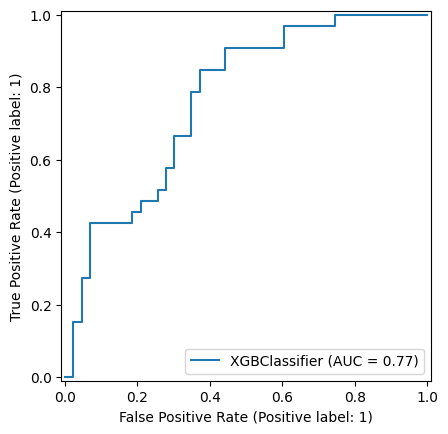

In [372]:
model_xgb = xgb.XGBClassifier(
    max_depth=13,
    learning_rate=0.5,
    n_estimators=89,
    subsample=0.8,  #enable_categorical=True,
)
scores, stimators = apply_cross_validation(model_xgb, X, Y)
print(scores.mean())
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=26)
model_xgb.fit(X_train, Y_train)
metrics.RocCurveDisplay.from_estimator(model_xgb, X_test, Y_test)
scores

['              precision    recall  f1-score   support',
 '',
 '         0.0       0.72      0.67      0.70        43',
 '         1.0       0.61      0.67      0.64        33',
 '',
 '    accuracy                           0.67        76',
 '   macro avg       0.67      0.67      0.67        76',
 'weighted avg       0.68      0.67      0.67        76',
 '']

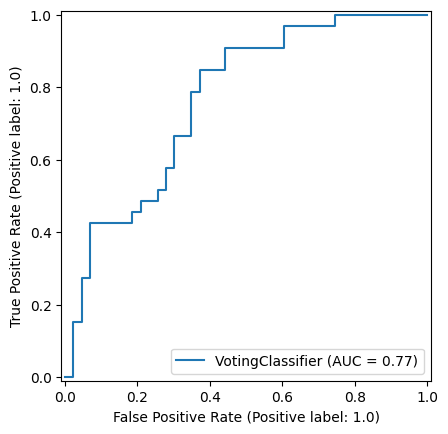

In [316]:
xg_ensemble, xg_evaluation = train_soft_voting(X, Y, stimators, scores)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=26)
model_xgb.fit(X_train, Y_train)
metrics.RocCurveDisplay.from_estimator(xg_ensemble, X_test, Y_test)
xg_evaluation.split('\n')

# Perceptron

fit_time           0.224962
score_time         0.009029
test_f1            0.719988
train_f1           0.937519
test_accuracy      0.716379
train_accuracy     0.936289
test_precision     0.704916
train_precision    0.921092
test_recall        0.758105
train_recall       0.955589
dtype: float64


,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.358441,0.019088,0.714286,0.932331,0.724138,0.929961,0.666667,0.911765,0.769231,0.953846
1,0.273813,0.012669,0.583333,0.949416,0.655172,0.949416,0.538462,0.976000,0.636364,0.924242
2,0.255752,0.001267,0.687500,0.939271,0.655172,0.941634,0.785714,0.950820,0.611111,0.928000
3,0.200578,0.016369,0.888889,0.934307,0.896552,0.929961,0.857143,0.888889,0.923077,0.984615
4,0.205994,0.012662,0.608696,0.941606,0.689655,0.937743,0.500000,0.921429,0.777778,0.962687
5,0.236384,0.003213,0.800000,0.938931,0.793103,0.937743,0.800000,0.917910,0.800000,0.960938
6,0.165926,0.006405,0.777778,0.934363,0.714286,0.934109,0.777778,0.902985,0.777778,0.968000
7,0.168858,0.016963,0.800000,0.938182,0.785714,0.934109,0.666667,0.895833,1.000000,0.984733
8,0.200294,0.000000,0.733333,0.931298,0.714286,0.930233,0.687500,0.917293,0.785714,0.945736
9,0.183584,0.001650,0.606061,0.935484,0.535714,0.937984,0.769231,0.928000,0.500000,0.943089


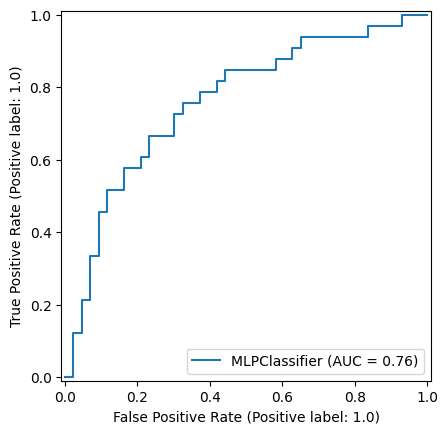

In [360]:
#Solo se configura capas ocultas, no se configura capa de entrada y de salida
#activation -> función activación de la oculta
#hidden_layer_sizes=5,7 -> dos capas ocultas con 5 neuronas y 7 neuronas
#learning_rate-> tamaño del paso constante o decreciente
#learning_rate_init-> valor tasa de aprendizaje
#momentum->
#max_iter-> iteaciones
#random_state-> semilla para generacion numeros seudoaletorios
modelNN = MLPClassifier(activation="tanh", hidden_layer_sizes=(11, 5), learning_rate='constant',
                        learning_rate_init=0.0062, momentum= 0.3, max_iter=4000, batch_size=100, random_state=3, solver='adam')
scores, nn_stimators = apply_cross_validation(modelNN, X_scaled, Y)
print(scores.mean())
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, stratify=Y, random_state=26)
modelNN.fit(X_train, Y_train)
metrics.RocCurveDisplay.from_estimator(modelNN, X_test, Y_test)
scores

['              precision    recall  f1-score   support',
 '',
 '         0.0       0.75      0.70      0.72        43',
 '         1.0       0.64      0.70      0.67        33',
 '',
 '    accuracy                           0.70        76',
 '   macro avg       0.69      0.70      0.69        76',
 'weighted avg       0.70      0.70      0.70        76',
 '']

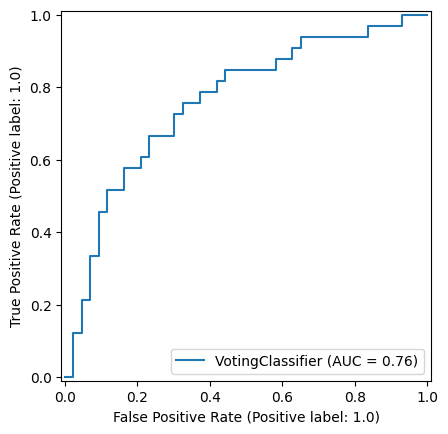

In [375]:
nn_ensemble, nn_evaluation = train_soft_voting(X_scaled, Y, nn_stimators, scores)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, stratify=Y, random_state=26)
modelNN.fit(X_train, Y_train)
metrics.RocCurveDisplay.from_estimator(nn_ensemble, X_test, Y_test)
nn_evaluation.split('\n')

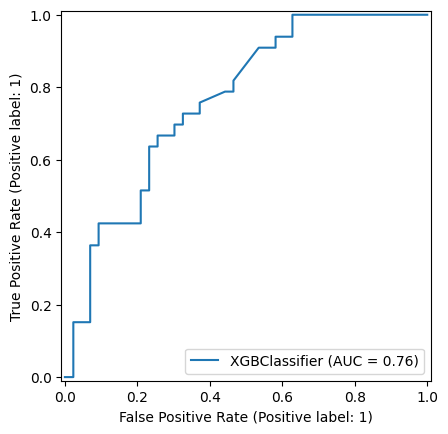

In [249]:
from sklearn import metrics
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=26)
model_xgb.fit(X_train, Y_train)
metrics.RocCurveDisplay.from_estimator(model_xgb, X_test, Y_test)

0    0.119048
1    0.050000
2    0.265957
3    0.119048
4    0.000000
5    0.181818
6    0.282609
7    0.100000
8    0.166667
9    0.333333
Name: test_f1, dtype: float64

In [6]:
from sklearn import metrics
metrics.RocCurveDisplay.from_estimator(model_vot_hard, X_test, Y_test)

NameError: name 'model_vot_hard' is not defined